# OKEAN netcdf module

There are nowadays several netcdf interfaces for python. But some years ago there was only scientific-python (before numpy!), then pycdf and later the now popular netcdf4-python. Because of this and because I was still an occasional gloomy pcwin user (no pycdf available), I created a netcdf front-end that could use scientific-python or pycdf, and later, netcdf4-python. This short tutorial illustrates the main features o the okean.netcdf module

The most useful tool is netcdf.use which lets you load data using dimension names and indices, ie, there is no need to know the order of the dimensions.

In [1]:
from okean import netcdf
f='http://apdrc.soest.hawaii.edu:80/dods/public_data/PODAAC/aquarius/v3_daily_bias_salt'
print netcdf.fdim(f)
print netcdf.varnames(f)

{u'lat': 180, u'lon': 360, u'time': 1345}
[u'time', u'lat', u'lon', u'salinity']


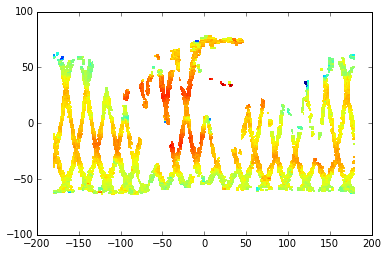

In [2]:
nc=netcdf.ncopen(f)
# because I will do several accesses to a remote file,
# better to open it only once, ie, use nc instead of f
# in all the functions of netcdf module

s=netcdf.use(nc,'salinity',time=1000)
lon=netcdf.use(nc,'lon',time=1000) # no need for time indice here!
lat=netcdf.use(nc,'lat',time=1000)

% matplotlib inline
import pylab as pl
pl.pcolormesh(lon,lat,s);

What if we try to get a wrong indice:

In [3]:
ss=netcdf.use(nc,'salinity',time=10000)
print ss

:: max allowed time = 1344
None


netcdf.nctime can load time as a datetime array if the variable has the attribute units:

In [4]:
att=netcdf.vatt(nc,'time')
if 'units' in att: print att['units']

time=netcdf.nctime(nc,'time',time=1000)
print time

units   <U26  days since 1-1-1 00:00:0.0
2014-05-21 00:00:00


Now, lets introduce here the [okean.vis](https://github.com/martalmeida/okean/blob/master/okean/documentation/okean_vis.ipynb) module which, among other things, can very easily produce maps:

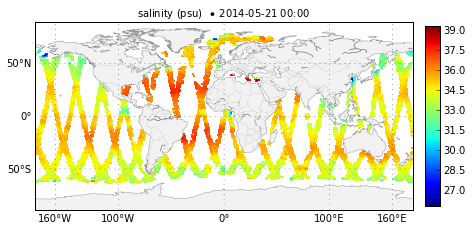

In [5]:
from okean import vis
o=vis.Data(lon,lat,s,t=time)

# Here t=time will be used only to genrate the title.
# Other useful info for the title is the main variable
# name (and maybe units):
o.info['v']['name']=netcdf.vatt(nc,'salinity','long_name')
o.plot(figsize=(7,5))

# let adjust colorbar size:
p=o.cb.ax.get_position()
p.y0,p.y1=.25,.75
o.cb.ax.set_position(p)

But maybe you want to load data from files with different dimension names. For instance ROMS time dimension can be time, ocean time,... even scrum_time. How o deal with this:

In [6]:
s=netcdf.use(nc,'salinity',timSEARCH=1000)
print s.shape

(180, 360)


You still can use netcdf.use to load data using ordered indices:

In [7]:
print netcdf.vdim(nc,'salinity').keys() # ordered dims

[u'time', u'lat', u'lon']


In [8]:
v=netcdf.use(nc,'salinity',**{'0':1000,'1':'20:50'})
print v.shape

(30, 360)


Extracting some region:

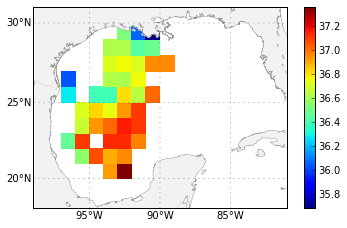

In [9]:
import numpy as np
xcond=np.where((lon>-100)&(lon<=-80))[0]
ycond=np.where((lat>17)&(lat<33))[0]

xcond=range(xcond.min(),xcond.max())
ycond=range(ycond.min(),ycond.max())

args=dict(lon=xcond,lat=ycond,time=1000)

v=netcdf.use(nc,'salinity',**args)
x=netcdf.use(nc,'lon',**args)
y=netcdf.use(nc,'lat',**args)
o=vis.Data(x=x,y=y,v=v)
o.plot(labels=0,figsize=(5,3.5))

OK, now for some reason you want to save this data in a netcdf file. You can write a rather long script or:

In [10]:
vars=dict(lon=x,lat=y,salt=v)
fname='/tmp/files/some.nc'
netcdf.dict2nc(fname,vars,perm='t')

# lets see the file contents:
netcdf.show(fname)


# Contents of the NetCDF file
   /tmp/files/some.nc

:: Global Attributes:

:: Dimensions:
   dim_0  14
   dim_1  19

:: Variables:
            long_name       units     shape  
   lat  |                |         | (14,)    |
   salt |                |         | (14, 19) |
   lon  |                |         | (19,)    |


It may look better with a few more lines:

In [11]:
tunits='hours since 2000-01-01'
tnum=netcdf.date2num(time,tunits)
vars=dict(lon=x,lat=y,salt=v,time=[tnum])

dims=dict(lon=v.shape[1],lat=v.shape[0],time=1)
vatts=dict(lon={'long_name': 'longitude'}, salt=dict(the_name='salinity'),
           time=dict(units=tunits))
atts=dict(history='just a test file')
fname2='/tmp/files/some2.nc'
netcdf.dict2nc(fname2,vars,dims,atts,vatts,perm='t')
netcdf.show(fname2,Lmax=30)


# Contents of the NetCDF file
   /tmp/files/some2.nc

:: Global Attributes:
   history  just a test file

:: Dimensions:
   lat   14
   lon   19
   time   1

:: Variables:
            long_name              units             shape  
   lat  |                |                        | (14,)    |
   salt |                |                        | (14, 19) |
   lon  | longitude      |                        | (19,)    |
   time |                | hours since 2000-01-01 | (1,)     |


netcdf.show will list file contents. To get more info about one variable use netcdf.show(filename,varname):

In [12]:
netcdf.show(fname2,'lon')


:: Dimensions:
   lon   19

:: Attributes:
   long_name   longitude

:: Shape: (19,)

:: Range: (-99.0, -81.0)


There are two bin tools which may be usefull. One is show, the other is show_nctime (info about time in file):

In [13]:
!show_nctime http://apdrc.soest.hawaii.edu:80/dods/public_data/PODAAC/aquarius/v3_daily_bias_salt

1345 reccords, from 2011-08-25 00:00:00 to 2015-04-30 00:00:00


In [14]:
# show filename # kind of ncdump...
# show filename varname 
!show /tmp/files/some.nc salt


:: Dimensions:
   dim_0   14
   dim_1   19

:: Attributes:

:: Shape: (14, 19)

:: Range: (35.684559, 37.36245)


netcdf tools rely on netcdf.Pync class. You can take a look but most of it is about netcdf4-python, although pycdf and scientific-python are still partially supported.

- - -
## Links

- [okean](https://github.com/martalmeida/okean/)

- [okean documentation](https://github.com/martalmeida/okean/blob/master/okean_doc.ipynb) - documentation index

- - -
*mma 2015*  